In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

from dGbyG.utils.custom_tools import rapid_process_result, rapid_linear_reg
from dGbyG.config import train_data_path

In [2]:
TrainingData_df = pd.read_csv(train_data_path)

In [3]:
TrainingData_df

,description,reaction,T,I,pH,pMg,standard_dg_prime,std,n,SEM,type,nontrans_standard_dg_prime,nontrans_std,all standard_dg_prime,all nontrans_standard_dg_prime
0,Nitrogen,N#N,298.15,0.25,7.0,14.0,18.700000,NaN,1,NaN,formation dg,NaN,NaN,NaN,NaN
1,"3,4,5-Trichlorobenzoate",[H]OC(=O)c1c([H])c(Cl)c(Cl)c(Cl)c1[H],298.15,0.25,7.0,14.0,-200.900000,NaN,1,NaN,formation dg,NaN,NaN,NaN,NaN
2,L-Glutamate,[H]OC(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O...,298.15,0.25,7.0,14.0,-372.400000,NaN,1,NaN,formation dg,NaN,NaN,NaN,NaN
3,Isomaltose,[H]OC1([H])O[C@]([H])(C([H])([H])O[C@@]2([H])O...,298.15,0.25,7.0,14.0,-691.300000,NaN,1,NaN,formation dg,NaN,NaN,NaN,NaN
4,L-Tryptophan,[H]OC(=O)[C@@]([H])(N([H])[H])C([H])([H])c1c([...,298.15,0.25,7.0,14.0,374.200000,NaN,1,NaN,formation dg,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,vitamin A alcohol(aq) + NAD(aq) = vitamin A al...,[H]OC([H])([H])/C([H])=C(C(/[H])=C([H])/C([H])...,298.15,0.25,7.0,14.0,10.394769,0.006827,3,0.003942,reaction dg,2.857408,5.934560,"[10.399259029155791, 10.39813468701262, 10.386...","[8.791967365371965, 2.8574077349915883, -3.077..."
671,xanthosine(aq) + orthophosphate(aq) = xanthine...,[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])...,298.15,0.25,7.0,14.0,11.113146,NaN,1,NaN,reaction dg,10.757583,NaN,[11.113145736479488],[10.75758344080382]
672,xylitol(aq) + NAD(aq) = D-xylulose(aq) + NADH(aq),[H]OC([H])([H])[C@]([H])(O[H])[C@@]([H])(O[H])...,298.15,0.25,7.0,14.0,19.321829,1.132922,7,0.428204,reaction dg,14.741046,4.899382,"[19.20588014608962, 18.034194744922512, 19.534...","[19.20588014608962, 18.034194744922512, 16.622..."
673,xylitol(aq) + NADP(aq) = D-xylose(aq) + NADPH(aq),[H]OC([H])([H])[C@]([H])(O[H])[C@@]([H])(O[H])...,298.15,0.25,7.0,14.0,15.610798,2.085702,2,1.474814,reaction dg,11.902316,3.296062,"[17.08561156767712, 14.135983787057135]","[14.232984264850018, 9.57164806317288]"


Read the cross validation results

In [6]:
TrainingData_df = pd.read_csv(train_data_path)
is_rxn = np.array([' = ' in r for r in TrainingData_df.loc[:,'reaction']])
real_r = TrainingData_df.loc[:,'standard_dg_prime'].to_numpy().reshape(-1)
mean_std = TrainingData_df.loc[:,'std'].mean()
SEM = TrainingData_df.loc[:,'SEM'].to_numpy()

Scale = []
for n, sem in zip(TrainingData_df.loc[:,'n'], TrainingData_df.loc[:,'SEM']):
    scale = mean_std if np.isnan(sem) else (sem**2 + mean_std**2/n)**0.5
    Scale.append(scale)
Scale = np.array(Scale)

results_dir = '../data/results_data/cross_validation_results'
Loss = []
Results = []
Final_p = []
R = []
for n in range(0,100):
    name = '10_fold_cross_validation_with_random_dG_'+str(n)
    loss = np.load(os.path.join(results_dir, name+'.npy')).mean(axis=0)
    res = pd.read_csv(os.path.join(results_dir, name+'.csv'), index_col=0)
    idx = np.argmin(loss)

    Loss.append(loss)
    Results.append(res)
    Final_p.append(res.loc[:,str(idx)].to_numpy())
    R.append(res['r'].to_numpy())

Loss = np.array(Loss)
R = np.array(R)
Final_p = np.array(Final_p)

Correlation between real values and the mean of predicted values

Medain of absolute error: 3.9764279999999417
Mean of absolute error: 8.561365223717779

The linear model is: Y = -1.4048 + 0.99494X
PearsonRResult(statistic=0.9975994755324903, pvalue=0.0)
SignificanceResult(statistic=0.9297931667081568, pvalue=2.513732821288745e-294)


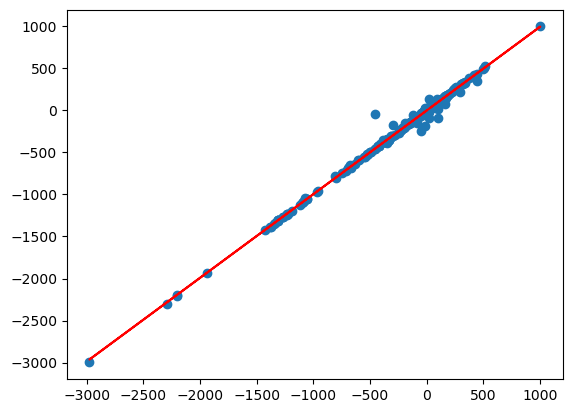

In [7]:
p = Final_p.mean(axis=0)
ae = np.abs(p - real_r)
print('Medain of absolute error:', np.median(ae))
print('Mean of absolute error:', np.mean(ae))
print()

x = rapid_linear_reg(real_r, Final_p.mean(axis=0), plot=True)

Interval

In [8]:
e = (p - real_r)
p_std = Final_p.std(axis=0)

m = gp.Model()
a = m.addVar(vtype="C", name='a')
b = m.addVar(vtype="C", name='b')


c =  p_std[is_rxn] * a + b#
ub = e[is_rxn] + c
lb = e[is_rxn] - c

n = m.addMVar(shape=c.shape[0], vtype='B', name='n')
n2 = m.addMVar(shape=c.shape[0], vtype='B', name='n2')

m.addConstrs((ub[i] <= 2000 * n[i] for i in range(c.shape[0])), name='ubu') # when 0<=ub<=2000, n=1, when -2000<=ub<=0, n=0
m.addConstrs((ub[i] >= -2000 * (1-n[i]) for i in range(c.shape[0])), name='ubl') 

m.addConstrs((lb[i] <= 2000 * (1-n2[i]) for i in range(c.shape[0])), name='lbu') # when -2000<=lb<=0, n2=1, when 0<=lb<=2000, n2=0
m.addConstrs((lb[i] >= -2000 * n2[i] for i in range(c.shape[0])), name='lbl')

m.addConstr(gp.quicksum(n * n2)>=c.shape[0]*0.95)
m.setParam('OutputFlag', 0)

m.setObjective(gp.quicksum(c), GRB.MINIMIZE)
m.optimize()
print(a.X, b.X)

1.9613420373346084 9.898636635043676


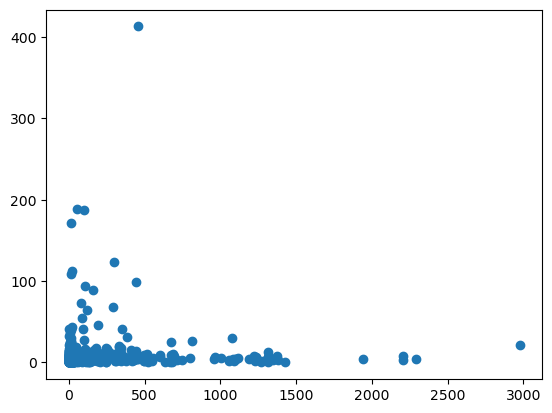

In [9]:
plt.scatter(abs(real_r), abs(e))